In [78]:
import torch
import utils
import constants
from dataset import prepare_dataloader

utils.set_seed(42)
parser = utils.get_parser()

opt = parser.parse_args(args=['-data', 
                              'data_sep/', 
                              '-n_layers', '2',
                              '-batch_size', '32', '-d_model', '32', "-d_inner_hid", '64', '-n_head', '2', '-lr', '1e-4',
                              '-model', 'cstpp', '-n_comps', '32', '-epoch', '10', '-device', '1'])
if torch.cuda.is_available() and opt.device != -1:
    opt.device = torch.device('cuda:' + str(opt.device))  
else:
    opt.device = torch.device('cpu')
print('[Info] parameters: {}'.format(opt))

trainloader, testloader, num_types = prepare_dataloader(opt)
time_scale = utils.get_time_scale(trainloader)
print('[Info] reloading data: scaling timestamps to {:.3f} times of the original'.format(1 / time_scale))
trainloader, testloader, num_types = prepare_dataloader(opt, time_scale)

batch = next(iter(trainloader)) # times, time intervals, markers, clusters

[Info] parameters: Namespace(agg='attn', batch_size=32, d_inner_hid=64, d_k=16, d_model=32, d_v=16, data='data_sep/', device=device(type='cuda', index=1), dropout=0.1, epoch=10, lr=0.0001, model='cstpp', n_comps=32, n_head=2, n_layers=2, smooth=0.1)
[Info] Loading train data...
[Info] Loading dev data...
[Info] Loading test data...
[Info] reloading data: scaling timestamps to 0.921 times of the original
[Info] Loading train data...
[Info] Loading dev data...
[Info] Loading test data...


In [79]:
times, intervals, markers, clusters = batch

In [80]:
import torch.nn.functional as F
from torch import nn, optim

import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
from models.eemb import EventEmb, TimeEncode
from models.tfm import TfmEnc, TfmEncLayer
from einops import rearrange, repeat

In [82]:
ee = EventEmb(d_model=opt.d_model, marker_num=num_types)
# x = ee(times, markers)

In [83]:
# pad_mask = (markers == constants.PAD) # (b, s)
# attn_mask = torch.triu(torch.ones(x.shape[-2], x.shape[-2]), diagonal=1).bool() # (s, s)

In [84]:
class InferenceNetwork(nn.Module):
    # q(Z | X)
    def __init__(self, d_model, n_layer, n_head, K):
        super().__init__()
        self.enc = TfmEnc(n_layer, TfmEncLayer, d_model=d_model, n_head=n_head)
        self.lin = nn.Linear(d_model, K)
        
    def forward(self, x, pad_mask, attn_mask):
        h = self.enc(x, pad_mask, attn_mask) # (b, s, d)
        logits = self.lin(h) # (b, s, k)
        return logits
        
net = InferenceNetwork(d_model=opt.d_model, n_layer=opt.n_layers, n_head=opt.n_head, K=opt.n_comps)
# logits = net(x, pad_mask, attn_mask)

In [85]:
# z = F.gumbel_softmax(logits, tau=0.1, hard=True) # b, s, k

In [86]:
from models.ctfm import cTfmEnc, cTfmEncLayer
    
cte = cTfmEnc(n_layer=3, layer=cTfmEncLayer, d_model=opt.d_model, n_head=opt.n_head)
# o = cte(x, z, pad_mask, attn_mask)

tpp_loss: -339.09356689453125 kl_loss: 0.00019827650976367295
ground truth:


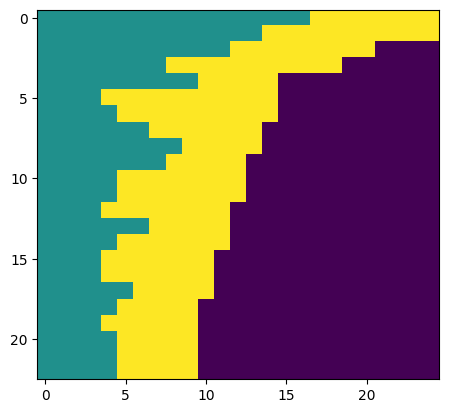

inference:


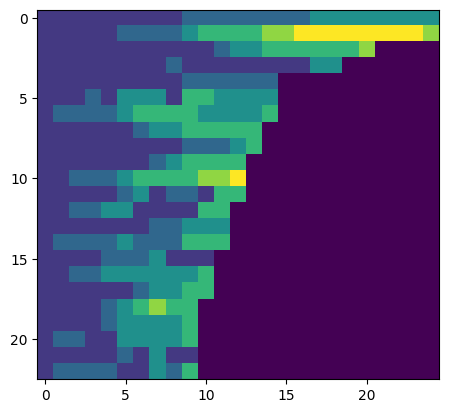

tpp_loss: -384.5162048339844 kl_loss: 4.48777100245934e-05
ground truth:


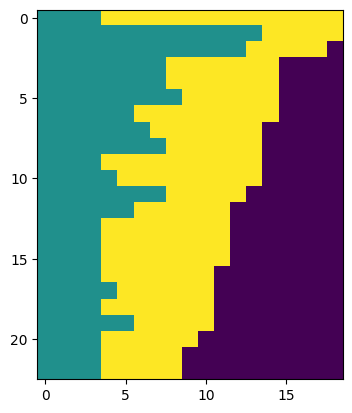

inference:


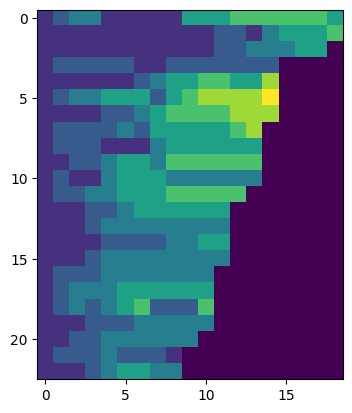

tpp_loss: -371.64532470703125 kl_loss: 1.57646481966367e-05
ground truth:


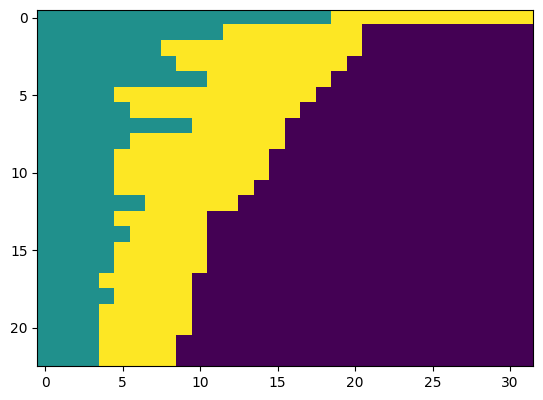

inference:


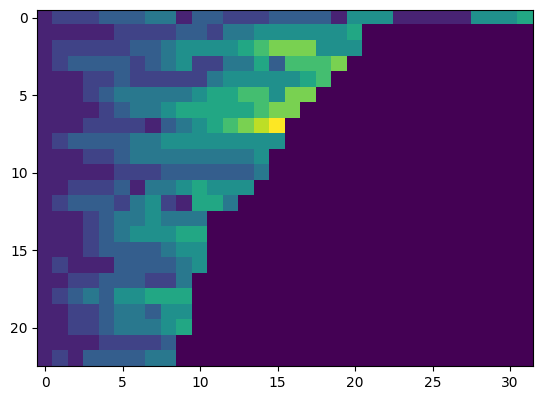

tpp_loss: -344.5213928222656 kl_loss: 1.0049680895463098e-05
ground truth:


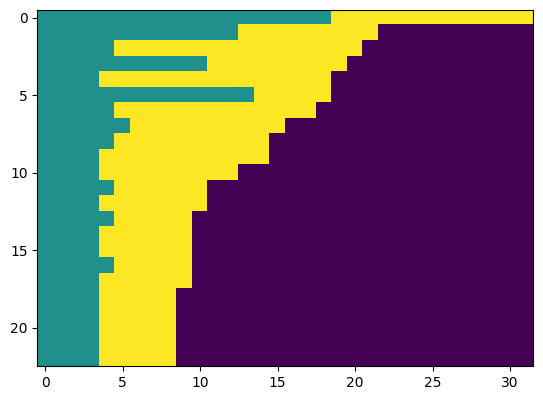

inference:


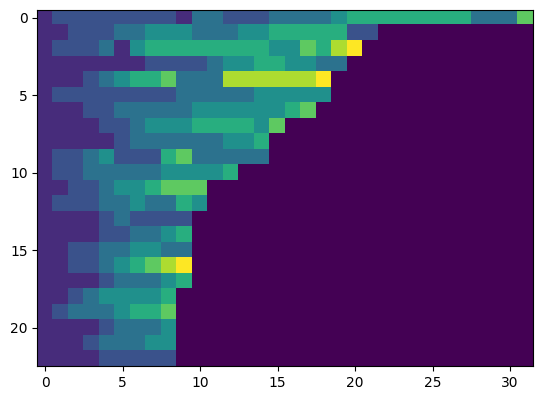

tpp_loss: -335.61834716796875 kl_loss: 9.676624358689878e-06
ground truth:


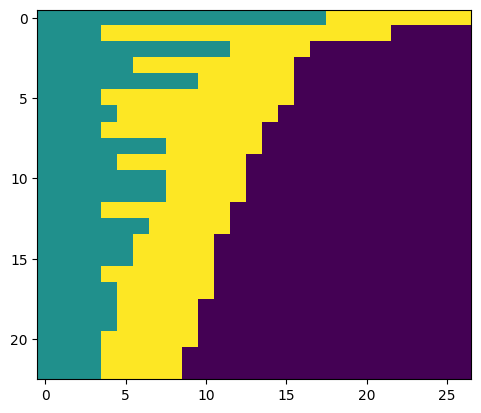

inference:


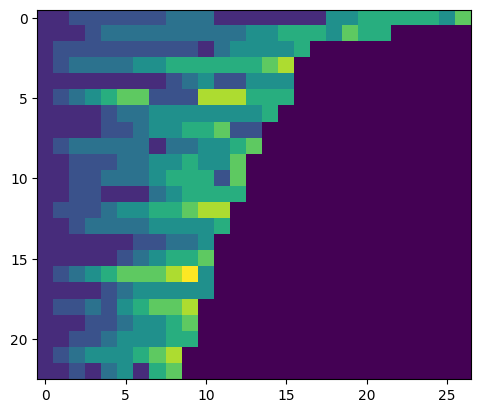

tpp_loss: -324.76031494140625 kl_loss: 6.763902092643548e-06
ground truth:


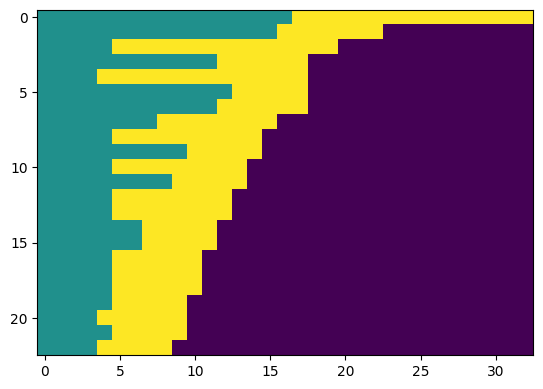

inference:


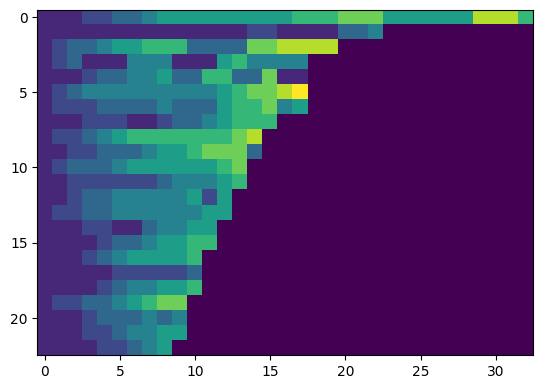

tpp_loss: -369.2631530761719 kl_loss: 6.36379672869225e-06
ground truth:


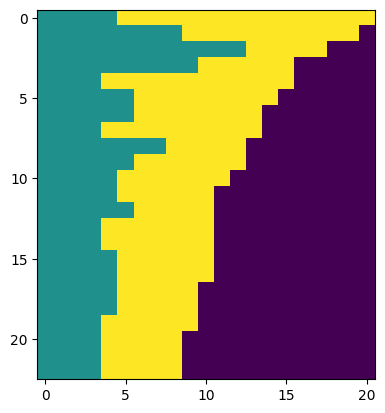

inference:


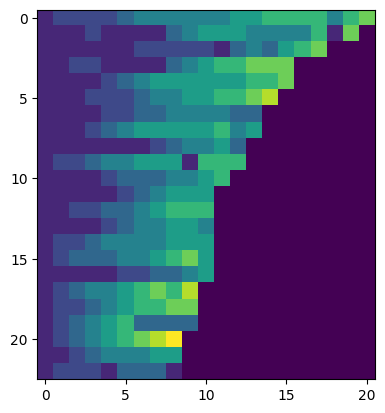

tpp_loss: -377.6019287109375 kl_loss: 5.187640908843605e-06
ground truth:


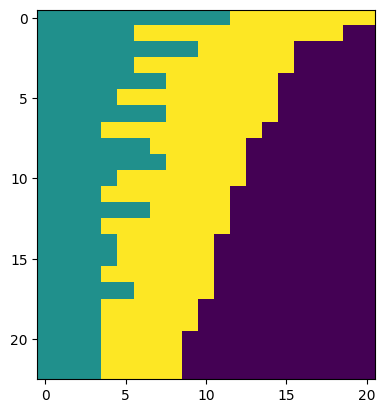

inference:


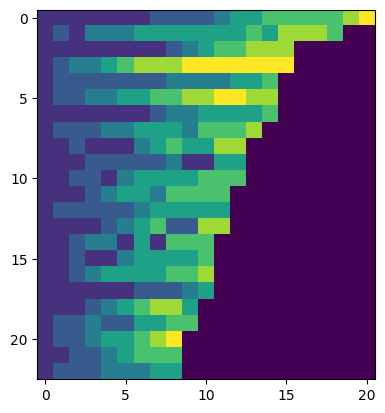

tpp_loss: -349.6446533203125 kl_loss: 4.319314484746428e-06
ground truth:


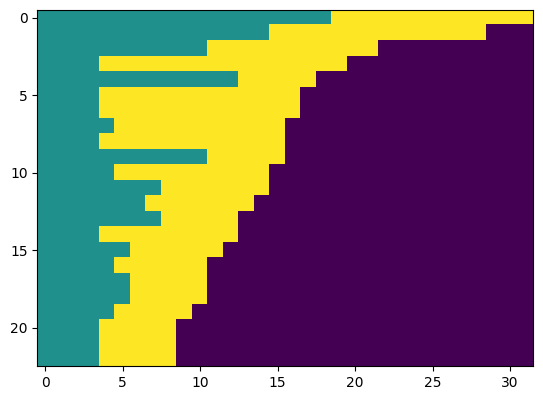

inference:


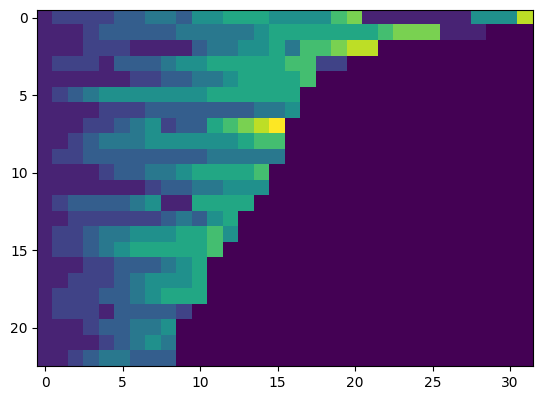

tpp_loss: -333.043212890625 kl_loss: 3.719952019309858e-06
ground truth:


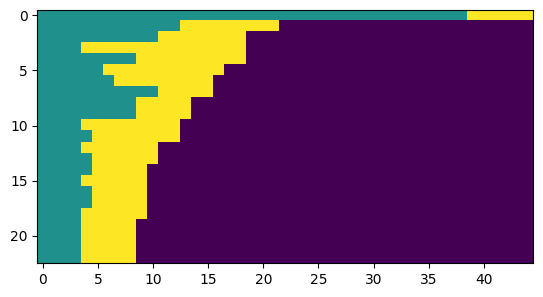

inference:


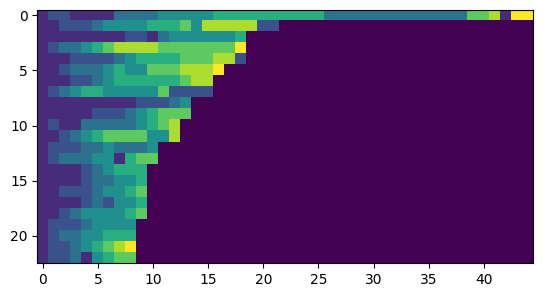

In [87]:
# o_last, t_last, t -> log_prob
from models.tpp import TPP
    
tpp = TPP(d_model=opt.d_model, marker_num=num_types, device=opt.device)

import itertools
optimizer = optim.Adam(itertools.chain(
    list(ee.parameters()),
    list(net.parameters()),
    list(cte.parameters()),
    list(tpp.parameters()),
))

for epo in range(10):
    for times, _, markers, comps in trainloader:
        # encoder
        x = ee(times, markers)
        pad_mask = (markers == constants.PAD) # (b, s)
        attn_mask = torch.triu(torch.ones(x.shape[-2], x.shape[-2]), diagonal=1).bool() # (s, s)
        logits = net(x, pad_mask, attn_mask)

        # loss
        tpp_loss = []
        for i in range(5):
            # sampler
            z = F.gumbel_softmax(logits, tau=10, hard=True) # b, s, k

            # decoder
            h = cte(x, z, pad_mask, attn_mask)
            h_last, dt_last, first_event_mask = utils.get_last_event_info(h, times, z, pad_mask, K=opt.n_comps) # last event in the same cluster
            tpp_loss.append(tpp.loss(h_last, dt_last, markers, first_event_mask | pad_mask))

        tpp_loss = torch.tensor(tpp_loss).mean()

        pi = F.softmax(logits, -1)
        kl = pi * torch.log(pi * opt.n_comps)
        kl = kl[~(first_event_mask | pad_mask)].mean()
        kl_loss = kl * 1

        l = tpp_loss + kl_loss

        # optim
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

    print('tpp_loss:', tpp_loss.item(), 'kl_loss:', kl_loss.item())
    print('ground truth:'); plt.imshow(comps[:, 1:]); plt.show()
    res = logits.argmax(-1)
    res[pad_mask] = -1
    print('inference:'); plt.imshow(utils.rearrange_z(res[:, 1:], opt).detach()); plt.show()
